# Finite Difference for 1D reaction-advection-diffusion problem

1. Finite Difference solver for the reaction-advection-diffusion problem with nonconstant coefficients:

$-\alpha(x) u''(x)+\beta(x) u'(x)+\gamma(x) u(x)=f(x) \quad \in (a,b)$

$u(a)=0, \quad u(b)=0$.

Implement FD method including the boundary conditions in the system.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

Function computing the 1D FD algebric system

In [18]:
def FD1D(omega,N,alpha,beta,gamma,rhs):
  # FD system matrix and rhs for
  # diffusion-advection-reaction problem with coeffs
  # alpha,beta,gamma,rhs
  # homogeneous Dirichlet bc
  # uniform grid in sparse CSR format

  # grid
  h = (omega[1]-omega[0])/N
  x =np.linspace(omega[0],omega[1],N+1)

  # compute coeffs and rhs values
  diff = alpha(x)
  conv = beta(x)
  reac = gamma(x)
  F = rhs(x)

  # assemble system matrix
  diff_term = [-diff[1:N+1], 2*diff, -diff[0:-1]]
  conv_term = [-conv[1:N+1], conv[0:-1]]

  A = (1./h**2) * sp.diags(diff_term,[-1,0,1],format="csr")+(1./(2*h)) * sp.diags(conv_term,[-1,1],format="csr") + sp.diags(reac,0,format="csr")

  # modify system to account for homogeneous Dirichlet boundary conditions
  A[0,0] = 1; A[0,1] = 0; F[0] = 0
  A[N,N] = 1; A[N,N-1] = 0; F[N] = 0

  return A, F

Solve the boundary value problem with:

$a=0,\, b=Π$

$\alpha(x)=1+\sin(x),\,  \beta(x)=1,\, \gamma(x)=x,\, f(x)=1$

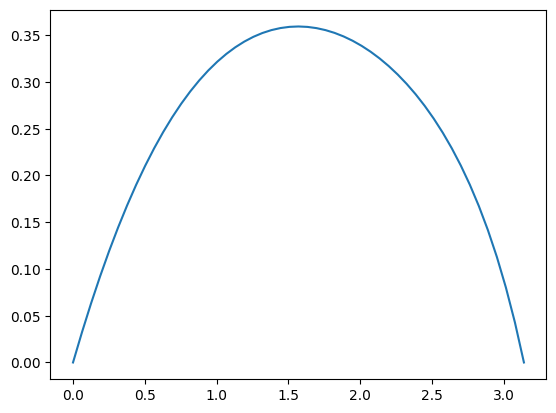

In [19]:
# Problem domain
omega =[0, np.pi]

# Problem data
alpha = lambda x : 1 + np.sin(x)
beta = lambda x : np.ones(len(x))
gamma = lambda x : x
rhs = lambda x : np.ones(len(x))

# Grid parameters
N=50
x =np.linspace(omega[0],omega[1],N+1)

# Assemble FD system
A, F = FD1D(omega,N,alpha,beta,gamma,rhs)

# solve
uh=sp.linalg.spsolve(A,F)

# plot solution
plt.plot(x,uh)


Compute experimental order of convergence (EOC) using knowledge that

$|| U-U_h ||_\infty \approx C h^k$

with $C$ independent of $h$. Hence,

$\frac{|| U-U_{h_1} ||_\infty}{|| U-U_{h_2} ||_\infty}\approx\large(\frac{h_1}{h_2}\large)^k$,

and then,

$k\approx\frac{\log || U-U_{h_1} ||_\infty-\log|| U-U_{h_2} ||_\infty}{\log h_1 - \log h_2}$.

Notice that to estimate the EOC you need to run at least two experiments, for instance with $h_1=h$, $h_2=h/2$.

For simplicity, let's take

$\alpha(x)=1,\,  \beta(x)=0,\, \gamma(x)=0$

and

$u=\sin(x)$ so that $f=\sin(x)$


In [35]:
# Problem domain
omega =[0, np.pi]

# Problem data
alpha = lambda x : np.ones(len(x))
beta = lambda x : 0. * np.ones(len(x))
gamma = lambda x : 0. * np.ones(len(x))
rhs = lambda x : np.sin(x)
u = lambda x : np.sin(x)

# Number of experiments
no_exp = 20

# initialise with first experiment
# Grid parameters
N=5
x =np.linspace(omega[0],omega[1],N+1)

# Assemble FD system
A, F = FD1D(omega,N,alpha,beta,gamma,rhs)

# solve
uh=sp.linalg.spsolve(A,F)

# compute error
err1 = max(abs(u(x)-uh))
h1 = (omega[1]-omega[0])/N


# loop over remaining experiments
for i in range(no_exp-1):
  # fix the mesh
  N = 2 * N
  x =np.linspace(omega[0],omega[1],N+1)

  # evaluate system for given N
  A, F = FD1D(omega,N,alpha,beta,gamma,rhs)
  # Solve
  uh=sp.linalg.spsolve(A,F)
  # Compute error
  err2 = max(abs(u(x)-uh))
  h2 = (omega[1]-omega[0])/N

  print(err2)
  #print((np.log(err1)-np.log(err2))/(np.log(h1)-np.log(h2)))

  # Update
  err1=err2
  h1=h2



0.008265416966228178
0.0020587067645332358
0.0005142004781475418
0.00012852038354571604
3.2128237817063976e-05
8.03194329468404e-06
2.0079784173177018e-06
5.019945084061561e-07
1.2550042538528317e-07
3.1377531239940026e-08
7.839531135367395e-09
1.9413302076998207e-09
5.0858350864047e-10
5.480762510501336e-10
8.979815779852629e-10
1.8215976504976084e-09
5.4958704143182047e-08
2.0782209619873981e-07
2.737376660899571e-07


What if the exact solution is not known? Then we can still estimate the EOC but three experiments. Indeed, letting $h_2=\theta h_1$, we have

$|| U_{h_2}-U_{h_1} ||_\infty\le || U-U_{h_1} ||_\infty + || U-U_{h_2} ||_\infty\approx C h_1^k+C h_2^k \approx C (1+\theta^k) h_1^k$

Now, given also $h_3 = \theta h_2$, we have similarly

$|| U_{h_3}-U_{h_2} ||_\infty \approx C (1+\theta^k) h_2^k=C (1+\theta^k)\theta^k h_1^k$

hence,

$\frac{|| U_{h_2}-U_{h_1} ||_\infty}{|| U_{h_3}-U_{h_2} ||_\infty}\approx \frac{C (1+\theta^k) h_1^k}{C (1+\theta^k)\theta^k h_1^k}=\theta^{-k}$

from which $k$ can be estimated as before by passing to the logs.

NOTE! The discrete solutions are defined at different sets of points so the above comparison is to be intended on the set of common points!

**Exercise 1:** try this out for the problem with

$\alpha(x)=1+\sin(x),\,  \beta(x)=1,\, \gamma(x)=x, \, f=1$.

Check that you still get the expected rate of convergence.

In [40]:
# Problem domain
omega =[0, np.pi]

# Problem data
alpha = lambda x : 1 + np.sin(x)
beta = lambda x : np.ones(len(x))
gamma = lambda x : x
rhs = lambda x : np.ones(len(x))

# Number of experiments
no_exp = 10

# Initial mesh
N=5

# Loop: three experiments at each iteration
for i in range(no_exp):
  N_1 = N
  N_2 = 2 * N_1
  N_3 = 2 * N_2
  
  # Evaluate system for given N
  A1, F1 = FD1D(omega,N_1,alpha,beta,gamma,rhs)
  A2, F2 = FD1D(omega,N_2,alpha,beta,gamma,rhs)
  A3, F3 = FD1D(omega,N_3,alpha,beta,gamma,rhs)
  
  # Solve
  uh1=sp.linalg.spsolve(A1,F1)
  uh2=sp.linalg.spsolve(A2,F2)
  uh3=sp.linalg.spsolve(A3,F3)
  
  # Select only points common to all three meshes
  uh2 = uh2[::2]
  uh3 = uh3[::4]
  
  # Compute errors
  err21 = max(abs(uh2-uh1))
  err32 = max(abs(uh3-uh2))
  
  # Compute convergence rates
  h1 = (omega[1]-omega[0])/N_1
  h2 = (omega[1]-omega[0])/N_2
  theta = h2/h1
  p = -(np.log(err21)-np.log(err32))/np.log(theta)
  
  print(p)
  
  # Update
  N = N_2
  




1.7974545275256701
1.9369170613656916
1.980497647849084
1.995356037886326
1.9987917124736752
1.9997027265288616
1.9999257467382048
1.9999793491533775
2.0000110138864415
1.9999913253120547


**Exercise 2.** Modify the FD1D routine to solve problems with nonhomogeneous boundary conditions.

In [49]:
def FD1D(omega,N,alpha,beta,gamma,rhs,uL,uR):
  # FD system matrix and rhs for
  # diffusion-advection-reaction problem with coeffs
  # alpha,beta,gamma,rhs
  # non-homogeneus Dirichlet bc
  # uniform grid in sparse CSR format

  # grid
  h = (omega[1]-omega[0])/N
  x =np.linspace(omega[0],omega[1],N+1)

  # compute coeffs and rhs values
  diff = alpha(x)
  conv = beta(x)
  reac = gamma(x)
  F = rhs(x)

  # assemble system matrix
  diff_term = [-diff[1:N+1], 2*diff, -diff[0:-1]]
  conv_term = [-conv[1:N+1], conv[0:-1]]

  A = (1./h**2) * sp.diags(diff_term,[-1,0,1],format="csr")+(1./(2*h)) * sp.diags(conv_term,[-1,1],format="csr") + sp.diags(reac,0,format="csr")

  # modify system to account for non-homogeneous Dirichlet boundary conditions
  A[0,0] = 1; A[0,1] = 0; F[0] = uL
  A[N,N] = 1; A[N,N-1] = 0; F[N] = uR

  return A, F

**Exercise 3.** Consider now the problem defined by:

$a=0$, $b=1$, $u(0)=1$, $u(1)=0$ $f=0$ and

$\alpha=\beta=\gamma=1$.

Solve this problem using a grid made of $N=10$ intervals and plot the solution.

Next, try with $\alpha=0.01$, $\beta=1$, $\gamma=0$. What happens? Can you explain? Experiment by taking finer grids.

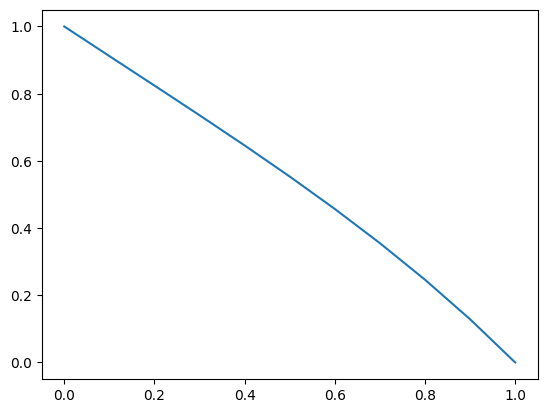

In [ ]:
# Problem domain
omega =[0, 1]

# Problem data
alpha = lambda x : np.ones(len(x))
beta = lambda x : np.ones(len(x))
gamma = lambda x : np.ones(len(x))
rhs = lambda x : np.zeros(len(x))
u_0 = 1
u_1 = 0

# Grid parameters
N=10
x =np.linspace(omega[0],omega[1],N+1)

# Assemble FD system
A, F = FD1D(omega,N,alpha,beta,gamma,rhs,u_0,u_1)

# solve
uh=sp.linalg.spsolve(A,F)

# plot solution
plt.plot(x,uh)

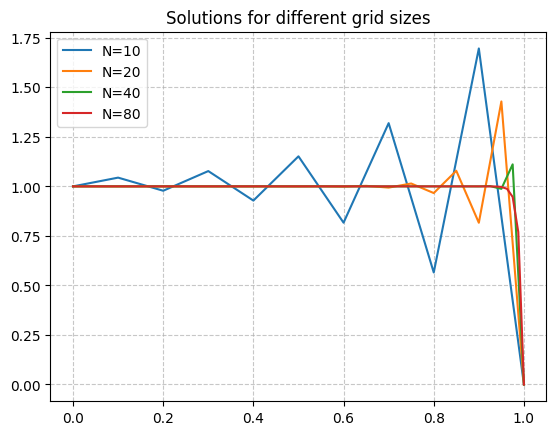

In [65]:
# Problem domain
omega =[0, 1]

# Problem data
alpha = lambda x : np.ones(len(x))/100
beta = lambda x : np.ones(len(x))
gamma = lambda x : np.zeros(len(x))
rhs = lambda x : np.zeros(len(x))
u_0 = 1
u_1 = 0

# Grid parameters
N=10
x =np.linspace(omega[0],omega[1],N+1)

# Assemble FD system
A, F = FD1D(omega,N,alpha,beta,gamma,rhs,u_0,u_1)

# solve
uh=sp.linalg.spsolve(A,F)

# Finer grids
N=20
x_1 =np.linspace(omega[0],omega[1],N+1)
A, F = FD1D(omega,N,alpha,beta,gamma,rhs,u_0,u_1)
uh_fine1=sp.linalg.spsolve(A,F)

N=40
x_2 =np.linspace(omega[0],omega[1],N+1)
A, F = FD1D(omega,N,alpha,beta,gamma,rhs,u_0,u_1)
uh_fine2=sp.linalg.spsolve(A,F)

N=80
x_3 =np.linspace(omega[0],omega[1],N+1)
A, F = FD1D(omega,N,alpha,beta,gamma,rhs,u_0,u_1)
uh_fine3=sp.linalg.spsolve(A,F)

# plot solution
plt.plot(x,uh,label="N=10")
plt.plot(x_1,uh_fine1,label="N=20")
plt.plot(x_2,uh_fine2,label="N=40")
plt.plot(x_3,uh_fine3,label="N=80")
plt.legend()
plt.grid(True, alpha=0.7, linestyle='--')
plt.title('Solutions for different grid sizes')
plt.show()

We can notice the fact that the numerical solution has oscillations when the grid is not fine enough. If we refine the grid, these oscillations gradually diminish and eventually disappear. This behavior, typical of numerical solutions of convection-dominated problems like this one, can be explained by the fact that the discrete maximum principle requires $\alpha\geq\frac{h}{2}|\beta|$: so if $\alpha$ is very small, $h$ must be very small enough too to prevent oscillations. In this case, we notice that as we refine the grid, the oscillations disappear: this happens when the grid is fine enough to satisfy the discrete maximum principle condition.